In [1]:
import numpy as np
import torch as pt
import torchvision
import torch
import torch.nn as nn
from torch.nn import functional as F
import torch.optim as optim
from torch.nn.init import xavier_uniform
from torch.utils.data import Dataset
from torch.autograd import Variable
import matplotlib.pyplot as plt
from collections import Counter
from sklearn.preprocessing import LabelBinarizer

In [2]:
#loading the train and test datasets using pytorch
train_dataset = torchvision.datasets.MNIST('../data', train=True, download=True,
                   transform=torchvision.transforms.Compose([
                       torchvision.transforms.ToTensor(),
                       torchvision.transforms.Normalize((0.1307,), (0.3081,))
                   ]))
test_dataset = torchvision.datasets.MNIST('../data', train=False, transform=torchvision.transforms.Compose([
                       torchvision.transforms.ToTensor(),
                       torchvision.transforms.Normalize((0.1307,), (0.3081,))
                   ]))

In [3]:
#this class has the helper functions to sample the train and test data to get the
#required number of samples from each set as asked in the assignemnt problem staement
from torch.utils.data.sampler import BatchSampler


class BalancedBatchSampler(BatchSampler):
    """
    BatchSampler - from a MNIST-like dataset, samples n_classes and within these classes samples n_samples.
    Returns batches of size n_classes * n_samples
    """

    def __init__(self, labels, n_classes, n_samples):
        self.labels = labels
        self.labels_set = list(set(self.labels.numpy()))
        self.label_to_indices = {label: np.where(self.labels.numpy() == label)[0]
                                 for label in self.labels_set}
        for l in self.labels_set:
            np.random.shuffle(self.label_to_indices[l])
        self.used_label_indices_count = {label: 0 for label in self.labels_set}
        self.count = 0
        self.n_classes = n_classes
        self.n_samples = n_samples
        self.n_dataset = len(self.labels)
        self.batch_size = self.n_samples * self.n_classes

    def __iter__(self):
        self.count = 0
        while self.count + self.batch_size <= self.n_dataset:
            classes = np.random.choice(self.labels_set, self.n_classes, replace=False)
            indices = []
            for class_ in classes:
                indices.extend(self.label_to_indices[class_][
                               self.used_label_indices_count[class_]:self.used_label_indices_count[
                                                                         class_] + self.n_samples])
                self.used_label_indices_count[class_] += self.n_samples
                if self.used_label_indices_count[class_] + self.n_samples > len(self.label_to_indices[class_]):
                    np.random.shuffle(self.label_to_indices[class_])
                    self.used_label_indices_count[class_] = 0
            yield indices
            self.count += self.n_classes * self.n_samples

    def __len__(self):
        return self.n_dataset // self.batch_size

In [4]:
#get 100 samples from each class (10 in total) making a total of 1000 samples to train
train_batch_smapler=BalancedBatchSampler(train_dataset.train_labels,n_classes=10,n_samples=100)
train_loader=torch.utils.data.DataLoader(train_dataset,batch_sampler=train_batch_smapler)

#get 10 samples from each class (10 in total) making a total of 100 samples to test
test_batch_smapler=BalancedBatchSampler(test_dataset.test_labels,n_classes=10,n_samples=10)
test_loader=torch.utils.data.DataLoader(test_dataset,batch_sampler=test_batch_smapler)

/home/sid/anaconda3/envs/pytorch/lib/python3.9/site-packages/torchvision/datasets/mnist.py:52: UserWarning: train_labels has been renamed targets
  warnings.warn("train_labels has been renamed targets")
/home/sid/anaconda3/envs/pytorch/lib/python3.9/site-packages/torchvision/datasets/mnist.py:57: UserWarning: test_labels has been renamed targets
  warnings.warn("test_labels has been renamed targets")


In [5]:
#select the first batch of 1000 samples from the data loader of train
for x,(d,t) in enumerate(train_loader):
    if x==0:
        train_data = d
        train_labels = t
    else:
        break
        
#select the first batch of 100 samples from the data loader of test
for x,(d,t) in enumerate(test_loader):
    if x==0:
        test_data = d
        test_labels = t
    else:
        break

## Question1 feed forward 

In [6]:
#function to initialize weights that would be updated further during the trainig process
def initialize_W(n):
    if isinstance(n, nn.Linear) or isinstance(n, nn.Conv2d):
        print('Initializing weights for layer: {0}'.format(n))
        xavier_uniform(n.weight)

In [7]:
# The convolution nueral network framework or the feed forward
#no drouputs and no batch normalization
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(1, 10, kernel_size=5) 
        self.conv2 = nn.Conv2d(10, 20, kernel_size=5)
        self.fc1 = nn.Linear(320, 50)
        self.fc2 = nn.Linear(50, 10)

    def forward(self, x):
        x = F.relu(F.max_pool2d(self.conv1(x), 2))
        x = F.relu(F.max_pool2d(self.conv2(x), 2))
        x = x.view(-1, 320)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return F.log_softmax(x, dim=1)

Cross entropy loss

In [8]:
loss_ce = nn.CrossEntropyLoss()

In [9]:
# train the CNN
#here the optimizer can be anything among vanilla SGd, momentum and RMSProp
def train(epoch,opt):
    model.train()
    data = Variable(train_data)
    target = Variable(train_labels)
    opt.zero_grad()
    ip = model(data)
    loss = loss_ce(ip, target)
    loss.backward()
    opt.step()

In [10]:
#function to test the CNN 
def test(epoch):
    X=[]
    model.eval()
    test_err = 0
    tp = 0
    data =  Variable(test_data, volatile=True)
    target = Variable(test_labels)
    output = model(data)
    test_err += loss_ce(output, target).data 
    pred = output.data.max(1, keepdim=True)[1] 
    tp += pred.eq(target.data.view_as(pred)).long().cpu().sum()
    
    if epoch==1 or epoch==15:
        X=pred
    test_err /= 100
    test_acc = 100. * tp / 100
    print(f"Test set results : loss = {test_err} , accuracy = {test_acc}")
    
    return test_err,test_acc,X

In [11]:
#function to calculate the train accuracy
def train_accuracy():
    model.eval()
    train_err = 0
    tp = 0
    data = Variable(train_data, volatile=True)
    target =  Variable(train_labels)
    output = model(data)
    train_err += loss_ce(output, target).data 
    pred = output.data.max(1, keepdim=True)[1] 
    tp += pred.eq(target.data.view_as(pred)).long().cpu().sum()
    train_err /= 1000
    train_accu= (tp/ 1000) *100
    print(f"Train set results : loss = {train_err} , accuracy = {train_accu}")
    return train_err,train_accu

## Question2

In [12]:
#initialize the model with the feed foward path mentioned above
model = Net()
model.apply(initialize_W) #initialize the wights for all the layers

Initializing weights for layer: Conv2d(1, 10, kernel_size=(5, 5), stride=(1, 1))
Initializing weights for layer: Conv2d(10, 20, kernel_size=(5, 5), stride=(1, 1))
Initializing weights for layer: Linear(in_features=320, out_features=50, bias=True)
Initializing weights for layer: Linear(in_features=50, out_features=10, bias=True)


/tmp/ipykernel_58727/3934088816.py:5: UserWarning: nn.init.xavier_uniform is now deprecated in favor of nn.init.xavier_uniform_.
  xavier_uniform(n.weight)


Net(
  (conv1): Conv2d(1, 10, kernel_size=(5, 5), stride=(1, 1))
  (conv2): Conv2d(10, 20, kernel_size=(5, 5), stride=(1, 1))
  (fc1): Linear(in_features=320, out_features=50, bias=True)
  (fc2): Linear(in_features=50, out_features=10, bias=True)
)

In [13]:
#Three optimizers to be tried
optimizer1 = optim.SGD(model.parameters(), lr=0.001)
optimizer2 = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)
optimizer3 = optim.RMSprop(model.parameters(),lr=0.001,alpha=0.9)

opt_list=[optimizer1,optimizer2,optimizer3]
opt_list_str=["Vanilla SGD","Momentum SGD","RMSProp"]

In [14]:
n_epochs = 15 #initialize the number of epochs
rows, cols = (3, n_epochs)

train_accu = np.zeros((rows, cols))
train_loss = np.zeros((rows, cols))
test_acc = np.zeros((rows, cols))
test_loss = np.zeros((rows, cols))

bt_layer1=[]
bt_layer15=[]

#perform taining for all the otimizers and store the results 
for i in range(3):  
    print(f"Training in process for {opt_list[i]}............")
    for epoch in range(1,  n_epochs+ 1):
        print('Epoch: {0}'.format(epoch))
        train(epoch,opt_list[i])
        a,b=train_accuracy()
        c,d,bt_layer=test(epoch)
        train_accu[i][epoch-1]=b
        test_acc[i][epoch-1]=(d)
        train_loss[i][epoch-1]=(a)
        test_loss[i][epoch-1]=(c)
        if epoch==1:
            bt_layer1=bt_layer
        if epoch==15:
            bt_layer15=bt_layer

Training in process for SGD (
Parameter Group 0
    dampening: 0
    lr: 0.001
    momentum: 0
    nesterov: False
    weight_decay: 0
)............
Epoch: 1
Train set results : loss = 0.0024614520370960236 , accuracy = 13.09999942779541
Test set results : loss = 0.024529753252863884 , accuracy = 16.0
Epoch: 2


/tmp/ipykernel_58727/2050569948.py:6: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
  data = Variable(train_data, volatile=True)
/tmp/ipykernel_58727/621324685.py:7: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
  data =  Variable(test_data, volatile=True)


Train set results : loss = 0.0024550054222345352 , accuracy = 13.199999809265137
Test set results : loss = 0.024467313662171364 , accuracy = 16.0
Epoch: 3
Train set results : loss = 0.00244875974021852 , accuracy = 13.300000190734863
Test set results : loss = 0.024406515061855316 , accuracy = 16.0
Epoch: 4
Train set results : loss = 0.002442702418193221 , accuracy = 13.199999809265137
Test set results : loss = 0.024347160011529922 , accuracy = 16.0
Epoch: 5
Train set results : loss = 0.0024368080776184797 , accuracy = 13.09999942779541
Test set results : loss = 0.0242893286049366 , accuracy = 16.0
Epoch: 6
Train set results : loss = 0.0024310918524861336 , accuracy = 13.40000057220459
Test set results : loss = 0.024232948198914528 , accuracy = 17.0
Epoch: 7
Train set results : loss = 0.0024255404714494944 , accuracy = 13.799999237060547
Test set results : loss = 0.02417813241481781 , accuracy = 17.0
Epoch: 8
Train set results : loss = 0.0024201488122344017 , accuracy = 13.7999992370605

## Question3

### 3(a)

#### Vanilla SGD

Train accuracy and test accuracy plot

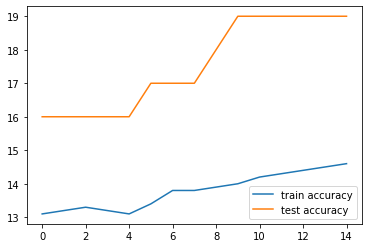

In [15]:
plt.plot(train_accu[0],label="train accuracy")
plt.plot(test_acc[0],label="test accuracy")
leg = plt.legend(loc='lower right')
plt.show()

Train loss and test loss plot

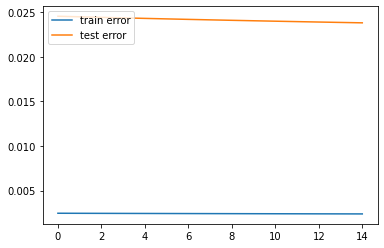

In [16]:
plt.plot(train_loss[0],label="train error")
plt.plot(test_loss[0],label="test error")
leg = plt.legend(loc='upper left')
plt.show()

#### Momentum SGD

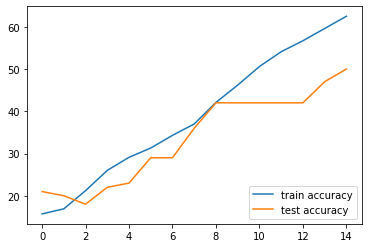

In [17]:
plt.plot(train_accu[1],label="train accuracy")
plt.plot(test_acc[1],label="test accuracy")
leg = plt.legend(loc='lower right')
plt.show()

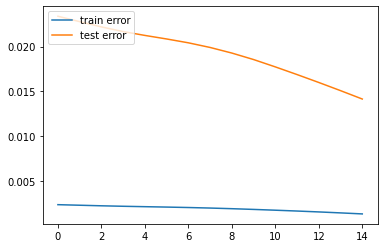

In [18]:
plt.plot(train_loss[1],label="train error")
plt.plot(test_loss[1],label="test error")
leg = plt.legend(loc='upper left')
plt.show()

#### RMSProp SGD

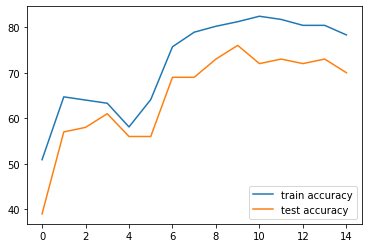

In [19]:
plt.plot(train_accu[2],label="train accuracy")
plt.plot(test_acc[2],label="test accuracy")
leg = plt.legend(loc='lower right')
plt.show()

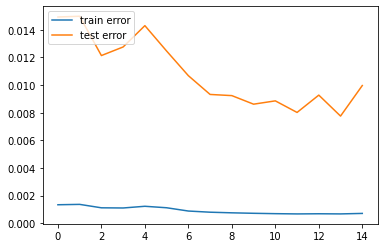

In [20]:
plt.plot(train_loss[2],label="train error")
plt.plot(test_loss[2],label="test error")
leg = plt.legend(loc='upper left')
plt.show()

### 3(c)

Accuracy by Vanilla SGD

In [21]:
print(f"test accuracy - {test_acc[0][14]} % ")

test accuracy - 19.0 % 


Accuracy by Momentum 

In [22]:
print(f"test accuracy - {test_acc[1][14]} % ")

test accuracy - 50.0 % 


Accuracy by RMSProp

In [23]:
print(f"test accuracy - {test_acc[2][14]} % ")

test accuracy - 70.0 % 


## Question4

In [24]:
from sklearn.manifold import TSNE
from matplotlib.colors import ListedColormap

keys = [0,1,2,3,4,5,6,7,8,9]
colour_list = ['blue', 'green', 'red', 'black', 'cyan', 'magenta', 'yellow','0.75', '#eebbbf', '#daddad', ]
def plot_tsne(bt_layer):
    tsne = TSNE(n_components=2,perplexity=5).fit_transform(bt_layer)
    tx = tsne[:, 0]
    ty = tsne[:, 1]
    
    colours= ListedColormap(colour_list)
    scatter=plt.scatter(tx,ty,marker='o',c=test_labels, cmap=colours)
    plt.legend(handles=scatter.legend_elements()[0], labels=keys)
    plt.show()

/home/sid/anaconda3/envs/pytorch/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/home/sid/anaconda3/envs/pytorch/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


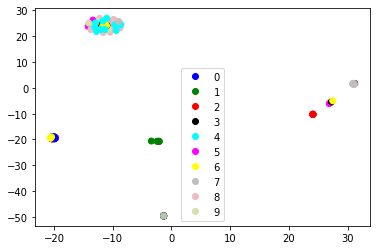

In [25]:
plot_tsne(bt_layer1)

/home/sid/anaconda3/envs/pytorch/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/home/sid/anaconda3/envs/pytorch/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


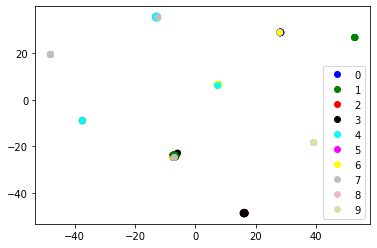

In [26]:
plot_tsne(bt_layer15)

## Question 5


Comaprision of the results from the previous assignemnt - The accuracy of the CNN with the vanilla SGD optimizer of the previous assignment is almost same as the ppytorch implementation written in this assignment. But the optimizer momentum has much improvement in the pytorxh implementation . There is a increace in the accuracy of around 30% and reduction in loss where as with the RMSProp optimizer, the accuracy has been boosted above 50% comapred to the one that was implemented in the previous assignemnt. 

## Question 6

In [27]:
#New CNN framework with dropout inclusive
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(1, 10, kernel_size=5) 
        self.conv2 = nn.Conv2d(10, 20, kernel_size=5)
        self.conv2_drop = nn.Dropout2d(p=p)
        self.fc1 = nn.Linear(320, 50)
        self.fc2 = nn.Linear(50, 10)

    def forward(self, x):
        x = F.relu(F.max_pool2d(self.conv1(x), 2))
        x = F.relu(F.max_pool2d(self.conv2_drop(self.conv2(x)), 2))
        x = x.view(-1, 320)
        x = F.relu(self.fc1(x))
        x = F.dropout(x, p=p, training=self.training)
        x = self.fc2(x)
        return F.log_softmax(x, dim=1)

### droupout rate 0.2

In [28]:
p = 0.20
model = Net()
model.apply(initialize_W)

optimizer1 = optim.SGD(model.parameters(), lr=0.001)
optimizer2 = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)
optimizer3 = optim.RMSprop(model.parameters(),lr=0.001,alpha=0.9)

opt_list=[optimizer1,optimizer2,optimizer3]

Initializing weights for layer: Conv2d(1, 10, kernel_size=(5, 5), stride=(1, 1))
Initializing weights for layer: Conv2d(10, 20, kernel_size=(5, 5), stride=(1, 1))
Initializing weights for layer: Linear(in_features=320, out_features=50, bias=True)
Initializing weights for layer: Linear(in_features=50, out_features=10, bias=True)


/tmp/ipykernel_58727/3934088816.py:5: UserWarning: nn.init.xavier_uniform is now deprecated in favor of nn.init.xavier_uniform_.
  xavier_uniform(n.weight)


In [29]:
n_epochs = 15
rows, cols = (3, n_epochs)

train_accu = np.zeros((rows, cols))
train_loss = np.zeros((rows, cols))
test_acc = np.zeros((rows, cols))
test_loss = np.zeros((rows, cols))

for i in range(3):  
    print(f"Training in process for {opt_list[i]}............")
    for epoch in range(1,  n_epochs+ 1):
        print('Epoch: {0}'.format(epoch))
        train(epoch,opt_list[i])
        a,b=train_accuracy()
        c,d,bt_layer=test(epoch)
        train_accu[i][epoch-1]=b
        test_acc[i][epoch-1]=(d)
        train_loss[i][epoch-1]=(a)
        test_loss[i][epoch-1]=(c)

Training in process for SGD (
Parameter Group 0
    dampening: 0
    lr: 0.001
    momentum: 0
    nesterov: False
    weight_decay: 0
)............
Epoch: 1
Train set results : loss = 0.002465511206537485 , accuracy = 15.09999942779541
Test set results : loss = 0.024811292067170143 , accuracy = 13.0
Epoch: 2


/tmp/ipykernel_58727/2050569948.py:6: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
  data = Variable(train_data, volatile=True)
/tmp/ipykernel_58727/621324685.py:7: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
  data =  Variable(test_data, volatile=True)


Train set results : loss = 0.00246006203815341 , accuracy = 15.299999237060547
Test set results : loss = 0.024757325649261475 , accuracy = 13.0
Epoch: 3
Train set results : loss = 0.0024550778325647116 , accuracy = 15.299999237060547
Test set results : loss = 0.024706723168492317 , accuracy = 14.0
Epoch: 4
Train set results : loss = 0.0024503315798938274 , accuracy = 15.399999618530273
Test set results : loss = 0.024659443646669388 , accuracy = 14.0
Epoch: 5
Train set results : loss = 0.002445848658680916 , accuracy = 15.399999618530273
Test set results : loss = 0.024614715948700905 , accuracy = 15.0
Epoch: 6
Train set results : loss = 0.002441348973661661 , accuracy = 15.299999237060547
Test set results : loss = 0.02456923946738243 , accuracy = 14.0
Epoch: 7
Train set results : loss = 0.0024371747858822346 , accuracy = 15.399999618530273
Test set results : loss = 0.02452738769352436 , accuracy = 15.0
Epoch: 8
Train set results : loss = 0.0024331272579729557 , accuracy = 15.5
Test set 

In [30]:
print(f"test accuracy: Vanilla SGd - {test_acc[0][14]} % ")
print(f"test accuracy: Momentum SGD - {test_acc[1][14]} % ")
print(f"test accuracy: RMSProp - {test_acc[2][14]} % ")

test accuracy: Vanilla SGd - 16.0 % 
test accuracy: Momentum SGD - 50.0 % 
test accuracy: RMSProp - 80.0 % 


### droupout rate 0.5

In [31]:
p = 0.50
model = Net()
model.apply(initialize_W)

optimizer1 = optim.SGD(model.parameters(), lr=0.001)
optimizer2 = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)
optimizer3 = optim.RMSprop(model.parameters(),lr=0.001,alpha=0.9)

opt_list=[optimizer1,optimizer2,optimizer3]

Initializing weights for layer: Conv2d(1, 10, kernel_size=(5, 5), stride=(1, 1))
Initializing weights for layer: Conv2d(10, 20, kernel_size=(5, 5), stride=(1, 1))
Initializing weights for layer: Linear(in_features=320, out_features=50, bias=True)
Initializing weights for layer: Linear(in_features=50, out_features=10, bias=True)


/tmp/ipykernel_58727/3934088816.py:5: UserWarning: nn.init.xavier_uniform is now deprecated in favor of nn.init.xavier_uniform_.
  xavier_uniform(n.weight)


In [32]:
n_epochs = 15
rows, cols = (3, n_epochs)

train_accu = np.zeros((rows, cols))
train_loss = np.zeros((rows, cols))
test_acc = np.zeros((rows, cols))
test_loss = np.zeros((rows, cols))

for i in range(3):  
    print(f"Training in process for {opt_list[i]}............")
    for epoch in range(1,  n_epochs+ 1):
        print('Epoch: {0}'.format(epoch))
        train(epoch,opt_list[i])
        a,b=train_accuracy()
        c,d,bt_layer=test(epoch)
        train_accu[i][epoch-1]=b
        test_acc[i][epoch-1]=(d)
        train_loss[i][epoch-1]=(a)
        test_loss[i][epoch-1]=(c)

Training in process for SGD (
Parameter Group 0
    dampening: 0
    lr: 0.001
    momentum: 0
    nesterov: False
    weight_decay: 0
)............
Epoch: 1
Train set results : loss = 0.0023865564726293087 , accuracy = 9.199999809265137
Test set results : loss = 0.023781204596161842 , accuracy = 9.0
Epoch: 2


/tmp/ipykernel_58727/2050569948.py:6: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
  data = Variable(train_data, volatile=True)
/tmp/ipykernel_58727/621324685.py:7: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
  data =  Variable(test_data, volatile=True)


Train set results : loss = 0.002383914776146412 , accuracy = 9.199999809265137
Test set results : loss = 0.02375505119562149 , accuracy = 9.0
Epoch: 3
Train set results : loss = 0.0023812823928892612 , accuracy = 9.199999809265137
Test set results : loss = 0.023728322237730026 , accuracy = 9.0
Epoch: 4
Train set results : loss = 0.002378756646066904 , accuracy = 9.199999809265137
Test set results : loss = 0.023703590035438538 , accuracy = 9.0
Epoch: 5
Train set results : loss = 0.0023762218188494444 , accuracy = 9.199999809265137
Test set results : loss = 0.023679036647081375 , accuracy = 9.0
Epoch: 6
Train set results : loss = 0.0023739896714687347 , accuracy = 9.199999809265137
Test set results : loss = 0.023657387122511864 , accuracy = 9.0
Epoch: 7
Train set results : loss = 0.0023717819713056087 , accuracy = 9.09999942779541
Test set results : loss = 0.023635728284716606 , accuracy = 9.0
Epoch: 8
Train set results : loss = 0.0023696590214967728 , accuracy = 9.199999809265137
Test s

In [33]:
print(f"test accuracy: Vanilla SGd - {train_accu[0][14]} % ")
print(f"test accuracy: Momentum SGD - {train_accu[1][14]} % ")
print(f"test accuracy: RMSProp - {train_accu[2][14]} % ")
print("\n")
print(f"test accuracy: Vanilla SGd - {test_acc[0][14]} % ")
print(f"test accuracy: Momentum SGD - {test_acc[1][14]} % ")
print(f"test accuracy: RMSProp - {test_acc[2][14]} % ")

test accuracy: Vanilla SGd - 9.0 % 
test accuracy: Momentum SGD - 18.0 % 
test accuracy: RMSProp - 76.0 % 


### dropout 0.8

In [34]:
p = 0.80
model = Net()
model.apply(initialize_W)

optimizer1 = optim.SGD(model.parameters(), lr=0.001)
optimizer2 = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)
optimizer3 = optim.RMSprop(model.parameters(),lr=0.001,alpha=0.9)

opt_list=[optimizer1,optimizer2,optimizer3]

Initializing weights for layer: Conv2d(1, 10, kernel_size=(5, 5), stride=(1, 1))
Initializing weights for layer: Conv2d(10, 20, kernel_size=(5, 5), stride=(1, 1))
Initializing weights for layer: Linear(in_features=320, out_features=50, bias=True)
Initializing weights for layer: Linear(in_features=50, out_features=10, bias=True)


/tmp/ipykernel_58727/3934088816.py:5: UserWarning: nn.init.xavier_uniform is now deprecated in favor of nn.init.xavier_uniform_.
  xavier_uniform(n.weight)


In [35]:
n_epochs = 15
rows, cols = (3, n_epochs)

train_accu = np.zeros((rows, cols))
train_loss = np.zeros((rows, cols))
test_acc = np.zeros((rows, cols))
test_loss = np.zeros((rows, cols))

for i in range(3):  
    print(f"Training in process for {opt_list[i]}............")
    for epoch in range(1,  n_epochs+ 1):
        print('Epoch: {0}'.format(epoch))
        train(epoch,opt_list[i])
        a,b=train_accuracy()
        c,d,bt_layer=test(epoch)
        train_accu[i][epoch-1]=b
        test_acc[i][epoch-1]=(d)
        train_loss[i][epoch-1]=(a)
        test_loss[i][epoch-1]=(c)

Training in process for SGD (
Parameter Group 0
    dampening: 0
    lr: 0.001
    momentum: 0
    nesterov: False
    weight_decay: 0
)............
Epoch: 1
Train set results : loss = 0.0024669310078024864 , accuracy = 9.600000381469727
Test set results : loss = 0.024419931694865227 , accuracy = 9.0
Epoch: 2


/tmp/ipykernel_58727/2050569948.py:6: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
  data = Variable(train_data, volatile=True)
/tmp/ipykernel_58727/621324685.py:7: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
  data =  Variable(test_data, volatile=True)


Train set results : loss = 0.0024528279900550842 , accuracy = 9.899999618530273
Test set results : loss = 0.024280225858092308 , accuracy = 9.0
Epoch: 3
Train set results : loss = 0.002441147807985544 , accuracy = 10.199999809265137
Test set results : loss = 0.024167928844690323 , accuracy = 9.0
Epoch: 4
Train set results : loss = 0.002429364947602153 , accuracy = 10.300000190734863
Test set results : loss = 0.02405483089387417 , accuracy = 9.0
Epoch: 5
Train set results : loss = 0.00242012832313776 , accuracy = 10.300000190734863
Test set results : loss = 0.023966338485479355 , accuracy = 9.0
Epoch: 6
Train set results : loss = 0.0024102863389998674 , accuracy = 10.40000057220459
Test set results : loss = 0.023873139172792435 , accuracy = 9.0
Epoch: 7
Train set results : loss = 0.0024018948897719383 , accuracy = 10.40000057220459
Test set results : loss = 0.023794330656528473 , accuracy = 9.0
Epoch: 8
Train set results : loss = 0.002395667601376772 , accuracy = 10.5
Test set results :

In [36]:
print(f"test accuracy: Vanilla SGd - {train_accu[0][14]} % ")
print(f"test accuracy: Momentum SGD - {train_accu[1][14]} % ")
print(f"test accuracy: RMSProp - {train_accu[2][14]} % ")
print("\n")
print(f"test accuracy: Vanilla SGd - {test_acc[0][14]} % ")
print(f"test accuracy: Momentum SGD - {test_acc[1][14]} % ")
print(f"test accuracy: RMSProp - {test_acc[2][14]} % ")

test accuracy: Vanilla SGd - 10.699999809265137 % 
test accuracy: Momentum SGD - 12.199999809265137 % 
test accuracy: RMSProp - 48.5 % 


test accuracy: Vanilla SGd - 10.0 % 
test accuracy: Momentum SGD - 12.0 % 
test accuracy: RMSProp - 49.0 % 


With the dropout being included in the CNN without batch normalization, the accuracy has dropped compared to the one without droput and without batch normalization. Thought ther is no significant difference in the loass and accuracy of the vanilla SGD, we can see quite a big difference in the same with the RMSProp and momentum optmizers. The accuracy of RMSProp has dropped from 85% to 42% on the test set.The same trend has been observed with the Train set as well. But one thing that is assureed in this is that , there is no ovefitting!

## Question 7

In [37]:
#New CNN framework with dropout and batch normalization as well
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(1, 10, kernel_size=5) 
        self.conv2 = nn.Conv2d(10, 20, kernel_size=5)
        self.conv2_bn = nn.BatchNorm2d(20)
        self.conv2_drop = nn.Dropout2d(p=p)
        self.fc1 = nn.Linear(320, 50)
        self.fc1_bn = nn.BatchNorm1d(50)
        self.fc2 = nn.Linear(50, 10)

    def forward(self, x):
        x = F.relu(F.max_pool2d(self.conv1(x), 2))
        x = F.relu(F.max_pool2d(self.conv2_drop(self.conv2_bn(self.conv2(x))), 2))
        x = x.view(-1, 320)
        x = F.relu(self.fc1(x))
        x = self.fc1_bn(x)
        x = F.dropout(x, p=p, training=self.training)
        x = self.fc2(x)
        return F.log_softmax(x, dim=1)

In [38]:
p = 0.2 #fix the droput at 0.2
model = Net()
model.apply(initialize_W)

optimizer1 = optim.SGD(model.parameters(), lr=0.001)
optimizer2 = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)
optimizer3 = optim.RMSprop(model.parameters(),lr=0.001,alpha=0.9)

opt_list=[optimizer1,optimizer2,optimizer3]

Initializing weights for layer: Conv2d(1, 10, kernel_size=(5, 5), stride=(1, 1))
Initializing weights for layer: Conv2d(10, 20, kernel_size=(5, 5), stride=(1, 1))
Initializing weights for layer: Linear(in_features=320, out_features=50, bias=True)
Initializing weights for layer: Linear(in_features=50, out_features=10, bias=True)


/tmp/ipykernel_58727/3934088816.py:5: UserWarning: nn.init.xavier_uniform is now deprecated in favor of nn.init.xavier_uniform_.
  xavier_uniform(n.weight)


In [39]:
n_epochs = 15
rows, cols = (3, n_epochs)

train_accu = np.zeros((rows, cols))
train_loss = np.zeros((rows, cols))
test_acc = np.zeros((rows, cols))
test_loss = np.zeros((rows, cols))

for i in range(3):  
    print(f"Training in process for {opt_list[i]}............")
    for epoch in range(1,  n_epochs+ 1):
        print('Epoch: {0}'.format(epoch))
        train(epoch,opt_list[i])
        a,b=train_accuracy()
        c,d,bt_layer=test(epoch)
        train_accu[i][epoch-1]=b
        test_acc[i][epoch-1]=(d)
        train_loss[i][epoch-1]=(a)
        test_loss[i][epoch-1]=(c)

Training in process for SGD (
Parameter Group 0
    dampening: 0
    lr: 0.001
    momentum: 0
    nesterov: False
    weight_decay: 0
)............
Epoch: 1
Train set results : loss = 0.002323963912203908 , accuracy = 11.399999618530273
Test set results : loss = 0.02292259782552719 , accuracy = 15.0
Epoch: 2


/tmp/ipykernel_58727/2050569948.py:6: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
  data = Variable(train_data, volatile=True)
/tmp/ipykernel_58727/621324685.py:7: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
  data =  Variable(test_data, volatile=True)


Train set results : loss = 0.0023145624436438084 , accuracy = 11.300000190734863
Test set results : loss = 0.022816358134150505 , accuracy = 16.0
Epoch: 3
Train set results : loss = 0.0023078895173966885 , accuracy = 11.0
Test set results : loss = 0.02273470349609852 , accuracy = 17.0
Epoch: 4
Train set results : loss = 0.002304164692759514 , accuracy = 10.899999618530273
Test set results : loss = 0.02267148718237877 , accuracy = 18.0
Epoch: 5
Train set results : loss = 0.0023022780660539865 , accuracy = 10.300000190734863
Test set results : loss = 0.02262379601597786 , accuracy = 17.0
Epoch: 6
Train set results : loss = 0.002301441505551338 , accuracy = 11.300000190734863
Test set results : loss = 0.022590387612581253 , accuracy = 18.0
Epoch: 7
Train set results : loss = 0.0023013995960354805 , accuracy = 12.199999809265137
Test set results : loss = 0.022562334313988686 , accuracy = 17.0
Epoch: 8
Train set results : loss = 0.002301674336194992 , accuracy = 11.90000057220459
Test set r

Vanilla SGD

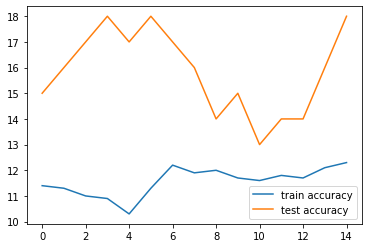

In [40]:
plt.plot(train_accu[0],label="train accuracy")
plt.plot(test_acc[0],label="test accuracy")
leg = plt.legend(loc='lower right')
plt.show()

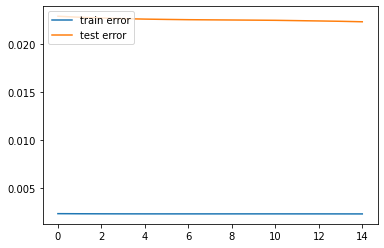

In [41]:
plt.plot(train_loss[0],label="train error")
plt.plot(test_loss[0],label="test error")
leg = plt.legend(loc='upper left')
plt.show()

Momentum

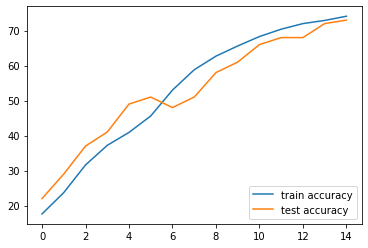

In [42]:
plt.plot(train_accu[1],label="train accuracy")
plt.plot(test_acc[1],label="test accuracy")
leg = plt.legend(loc='lower right')
plt.show()

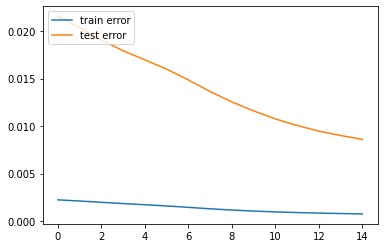

In [43]:
plt.plot(train_loss[1],label="train error")
plt.plot(test_loss[1],label="test error")
leg = plt.legend(loc='upper left')
plt.show()

RMSProp SGD

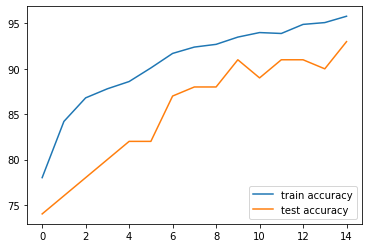

In [44]:
plt.plot(train_accu[2],label="train accuracy")
plt.plot(test_acc[2],label="test accuracy")
leg = plt.legend(loc='lower right')
plt.show()

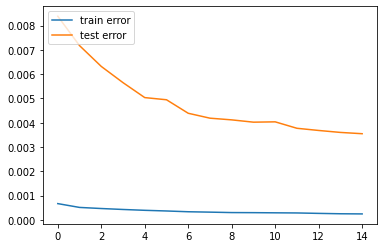

In [45]:
plt.plot(train_loss[2],label="train error")
plt.plot(test_loss[2],label="test error")
leg = plt.legend(loc='upper left')
plt.show()

In [46]:
print(f"test accuracy: Vanilla SGd - {train_accu[0][14]} % ")
print(f"test accuracy: Momentum SGD - {train_accu[1][14]} % ")
print(f"test accuracy: RMSProp - {train_accu[2][14]} % ")
print("\n")
print(f"test accuracy: Vanilla SGd - {test_acc[0][14]} % ")
print(f"test accuracy: Momentum SGD - {test_acc[1][14]} % ")
print(f"test accuracy: RMSProp - {test_acc[2][14]} % ")

test accuracy: Vanilla SGd - 12.300000190734863 % 
test accuracy: Momentum SGD - 74.0999984741211 % 
test accuracy: RMSProp - 95.80000305175781 % 


test accuracy: Vanilla SGd - 18.0 % 
test accuracy: Momentum SGD - 73.0 % 
test accuracy: RMSProp - 93.0 % 


Comaprision with the Vanilla SGD - Asa we can clearly see from the results, that the accuracy has been tremendously increased in the momentum and RMSProp implementation with a huge margin of 70 %. The model performs the best with the RMSProp optimizer rather then vanilla SGD

Comparision with Queestion6 - With the addition of batch normalization to the dropout, the model performs better. It gives lesser loss and greater accuracy on the test set. The test accuracy of the RMSProp has increased from 50% to 93% and the train accuracy from 49% to 95% after the addition of the batch normalization. 

The best CNN framework so far is the one that has both dropout and batch normalization.